In [1]:
import time
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import multiprocessing
from PIL import Image
# import standard PyTorch modules
import torch
import torch.nn as nn
import torch.optim as optim

# import torchvision module to handle image manipulation
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F

print("Running on torch.__version__ = ", torch.__version__)

torch.backends.cudnn.deterministic = True

# utils
import os
from tqdm import tqdm
tqdm.pandas()
from collections import Counter
import IPython.display as display

Running on torch.__version__ =  1.13.1+cu116


In [2]:
# Set the device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# a function to plot a batch of images together
def plot_images(img, ax):
    img = torchvision.utils.make_grid(img.cpu())
    npimg = img.numpy()
    ax.imshow(np.transpose(npimg, (1, 2, 0)))

def dict_to_device(orig, device):
    new = {}
    for k,v in orig.items():
        new[k] = v.to(device)
    return new

In [4]:
class GrainMapDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.grainmap_df = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.grainmap_df)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, str(idx + 1) + '.png')
        image = Image.open(img_path).convert('RGB')
        label = self.grainmap_df.iloc[idx]['Grain Number']
        
        if self.transform:
            image = self.transform(image)

        return image[:3, :, :], label



# Define the transform with normalization
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], inplace=True)
])
dataset = GrainMapDataset(csv_file='dataset/label.csv', root_dir='dataset/original', transform=transform)


In [5]:
# Set the number of workers to the number of available CPU cores
num_workers = multiprocessing.cpu_count()
print("[INFO] Number of workers:", num_workers)
# Training and validation split
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=True, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=True, num_workers=0)

print("[INFO] Train set size:", len(train_loader.dataset))
print("[INFO] Validation set size:", len(val_loader.dataset))
print("[INFO] Test set size:", len(test_loader.dataset))


[INFO] Number of workers: 16
[INFO] Train set size: 1920
[INFO] Validation set size: 480
[INFO] Test set size: 600


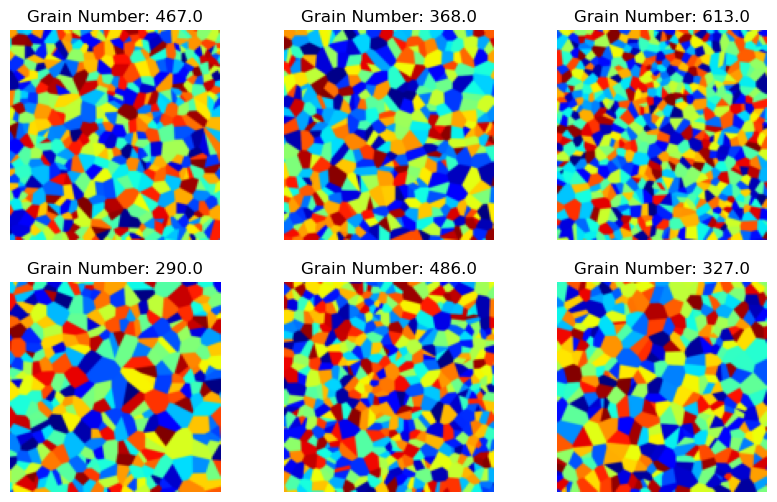

In [6]:
# Select 6 random indices from the training set
indices = torch.randint(len(train_dataset), size=(6,))

# Get the corresponding images and labels
images = [train_dataset[i][0] for i in indices]
labels = [train_dataset[i][1] for i in indices]

# Unnormalize the images
for i in range(6):
    images[i] = ((images[i] * 0.5) + 0.5) * 255  # Un-normalize and scale to 0-255

# Plot the images and display their labels
fig, axs = plt.subplots(2, 3, figsize=(10, 6))
axs = axs.flatten()
for i in range(6):
    axs[i].imshow(images[i].permute(1, 2, 0).numpy().astype(np.uint8))
    axs[i].set_title('Grain Number: {}'.format(labels[i]))
    axs[i].axis('off')
plt.show()

In [7]:
num_batches_train = len(train_loader.dataset) // train_loader.batch_size
print("Number of batches in the train set:", num_batches_train)

Number of batches in the train set: 120


In [8]:
class GrainSizeCNN(nn.Module):
    def __init__(self):
        super(GrainSizeCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 16 * 16, 512)
        self.fc2 = nn.Linear(512, 1)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 16 * 16)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = GrainSizeCNN().to(device)
print(model)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5, verbose=True)

GrainSizeCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=32768, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=1, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


Epoch: 1/50, Train Loss: 25965.0123, Validation Loss: 3451.4517
Epoch: 2/50, Train Loss: 2310.9151, Validation Loss: 747.1860
Epoch: 3/50, Train Loss: 1560.7126, Validation Loss: 1292.1820
Epoch: 4/50, Train Loss: 1318.9607, Validation Loss: 1070.2287
Epoch: 5/50, Train Loss: 1041.6867, Validation Loss: 1659.8906
Epoch: 6/50, Train Loss: 2535.4723, Validation Loss: 3070.8452
Epoch: 7/50, Train Loss: 2194.0761, Validation Loss: 590.8017
Epoch: 8/50, Train Loss: 1125.4209, Validation Loss: 754.8130
Epoch: 9/50, Train Loss: 1115.4707, Validation Loss: 545.2208
Epoch: 10/50, Train Loss: 1222.2959, Validation Loss: 1203.7643
Epoch: 11/50, Train Loss: 1236.1927, Validation Loss: 480.1364
Epoch: 12/50, Train Loss: 905.2923, Validation Loss: 1010.4260
Epoch: 13/50, Train Loss: 1284.4481, Validation Loss: 652.1424
Epoch: 14/50, Train Loss: 1019.8926, Validation Loss: 748.5654
Epoch: 15/50, Train Loss: 982.4851, Validation Loss: 777.3149
Epoch: 16/50, Train Loss: 896.8911, Validation Loss: 530.2

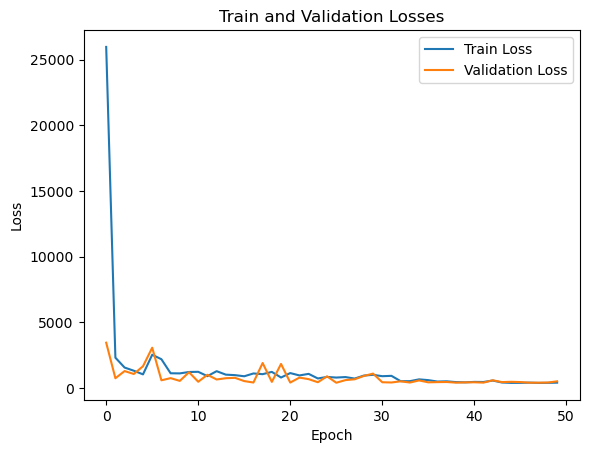

In [9]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs.view(-1), labels.float())
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
    return running_loss / len(dataloader.dataset)

def val_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs.view(-1), labels.float())

            running_loss += loss.item() * images.size(0)
    return running_loss / len(dataloader.dataset)

# Initialize lists to store train and validation losses
train_losses = []
val_losses = []

n_epochs = 50
best_val_loss = float('inf')

for epoch in range(n_epochs):
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss = val_epoch(model, val_loader, criterion, device)
    scheduler.step(val_loss)

    # Append the train and validation losses
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print("Epoch: {}/{}, Train Loss: {:.4f}, Validation Loss: {:.4f}".format(epoch+1, n_epochs, train_loss, val_loss))

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')

# Plot the train and validation losses
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Losses')
plt.legend()
plt.show()


In [14]:
model.load_state_dict(torch.load('best_model.pth'))

def evaluate(model, dataloader, device):
    model.eval()
    predictions = []
    ground_truth = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            predictions.extend(outputs.view(-1).cpu().numpy())
            ground_truth.extend(labels.cpu().numpy())

    return predictions, ground_truth

predictions, ground_truth = evaluate(model, test_loader, device)




In [11]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(ground_truth, predictions)
mae = mean_absolute_error(ground_truth, predictions)
r2 = r2_score(ground_truth, predictions)

print("Mean Squared Error (MSE): {:.4f}".format(mse))
print("Mean Absolute Error (MAE): {:.4f}".format(mae))
print("R-squared (R2): {:.4f}".format(r2))

Mean Squared Error (MSE): 424.6148
Mean Absolute Error (MAE): 16.0894
R-squared (R2): 0.9884


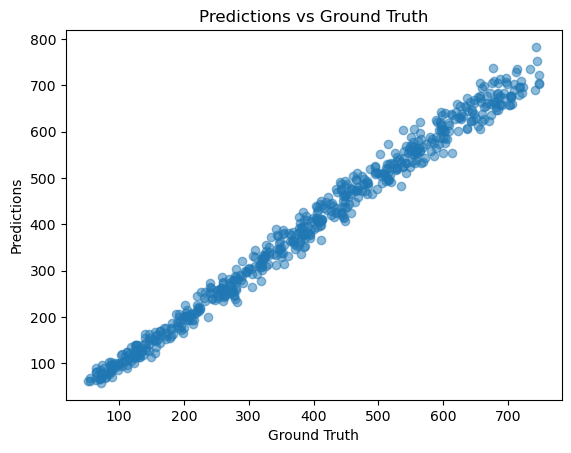

In [12]:
import matplotlib.pyplot as plt

plt.scatter(ground_truth, predictions, alpha=0.5)
plt.xlabel('Ground Truth')
plt.ylabel('Predictions')
plt.title('Predictions vs Ground Truth')
plt.show()

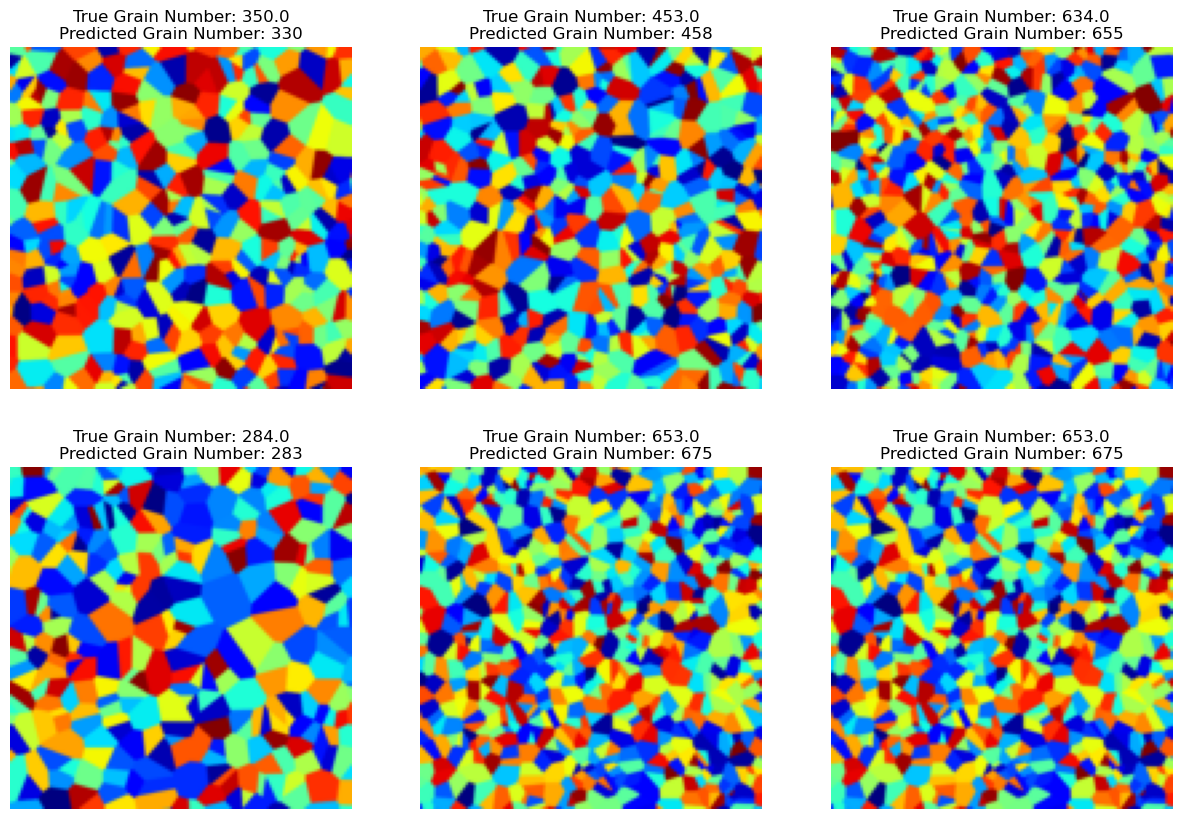

In [13]:
# Randomly select 6 indices from the test dataset
indices = torch.randint(len(test_dataset), size=(6,))

# Get the images, ground truth grain numbers, and predicted grain numbers
images = [test_dataset[i][0] for i in indices]
ground_truth = [test_dataset[i][1] for i in indices]
images_tensor = torch.stack(images).to(device)
predictions_tensor = model(images_tensor)
predictions = predictions_tensor.view(-1).cpu().detach().numpy()

# Unnormalize the images
for i in range(6):
    images[i] = ((images[i] * 0.5) + 0.5) * 255  # Un-normalize and scale to 0-255

# Plot the images along with the ground truth and predicted grain numbers
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs = axs.flatten()

for i in range(6):
    axs[i].imshow(images[i].permute(1, 2, 0).numpy().astype(np.uint8))
    rounded_prediction = int(round(predictions[i]))
    axs[i].set_title('True Grain Number: {}\nPredicted Grain Number: {}'.format(ground_truth[i], rounded_prediction))
    axs[i].axis('off')

plt.show()